In [1]:
import pandas as pd
import numpy as np
from src.scoring import *
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_roc_curve
import seaborn as sn

%matplotlib inline
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_csv('data/Task2data.csv')
y = df.pop('fraud')
df.head()

,amount,hour,zip1,id#,field2,flag1,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5,field1_0,field1_1,field1_2,field1_3
0,12.95,0,986,1234567890123456,0,0,-723,19,0,0,0,0,0,1,1,0,0,0
1,38.85,0,980,1234567890123457,1,0,5497,14,1,0,0,1,0,1,0,0,0,1
2,38.85,0,402,1234567890123458,1,0,-4420,23,0,0,1,1,0,1,0,0,1,0
3,12.95,0,958,1234567890123459,0,0,5010,31,0,0,1,0,0,1,0,0,0,1
4,38.85,0,300,1234567890123460,1,0,-4074,21,0,0,1,0,0,1,0,0,0,1


In [3]:
#We'll make 2 splits - our holdout will be our unseen data that we'll use later to compare all models
#X_main will be split further for model analysis
X_main, X_holdout, y_main, y_holdout = train_test_split(df, y, random_state=7, stratify=y)

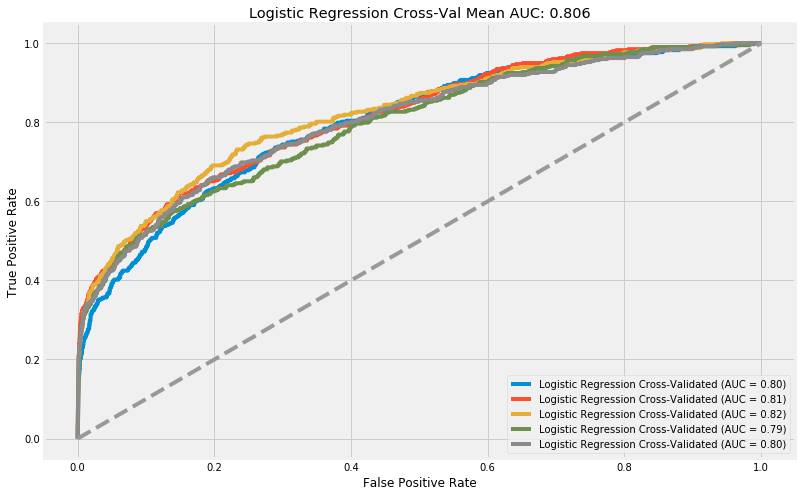

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))

kf = StratifiedKFold(n_splits=5, shuffle=True)
LR = LogisticRegression(solver='lbfgs',max_iter=10000, class_weight='balanced', tol=.0001)
scaler = StandardScaler()
AUCs = []

for i, (train_index, test_index) in enumerate(kf.split(X_main, y_main)):
    X_train, X_test = X_main.iloc[train_index], X_main.iloc[test_index]
    y_train, y_test = y_main.iloc[train_index], y_main.iloc[test_index]

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    LR.fit(X_train_scaled, y_train)
    plot_roc_curve(LR, X_test_scaled, y_test.values, name=f'Logistic Regression Cross-Validated', ax=ax)
    AUCs.append(metrics.roc_auc_score(y_test.values, LR.predict_proba(X_test_scaled)[:,1]))
    
mean_auc = round(np.mean(AUCs), 3)
ax.set_title(f'Logistic Regression Cross-Val Mean AUC: {mean_auc}')  
ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')

In [5]:
for feature, coef in zip(df.columns, LR.coef_[0]):
    print (feature, ":", round(coef,4))

amount : -0.1982
hour : -0.0474
zip1 : 0.0646
id# : -0.1439
field2 : -0.1746
flag1 : 0.4733
field3 : 0.0879
field4 : 0.0149
indicator1 : 0.0873
indicator2 : 0.0784
flag2 : -0.602
flag3 : 0.1951
flag4 : -0.0799
flag5 : 0.4875
field1_0 : -0.7659
field1_1 : -0.5175
field1_2 : -1.2259
field1_3 : -1.3202


In [6]:
import pickle 
with open('models/logistic.pkl', 'wb') as f:
    pickle.dump(LR, f)

In [6]:
'''df['field4_sqd'] = df.field4 ** 2
df['field4_log'] = np.log(df.field4)
df['zip_log'] = np.log(df.zip1)'''